In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
from openai import OpenAI
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from torchsummary import summary
import tensorflow as tf
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

# Data visualization

## Load Training dataset

In [2]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [3]:
#Frenk dataset
df_train = pd.read_csv('data/frenk_train_8404.tsv',sep='\t')
frenk_train = get_texts(df_train)
frenk_label_train = df_train["label"].to_numpy()

In [4]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train_8404.tsv',sep='\t')
try_train = get_texts(df_train)
try_label_train = df_train['label'].to_numpy()

In [5]:
#Concatenation of the two training datasets
conc_train = frenk_train + try_train
labels_conc_train = np.concatenate([frenk_label_train,try_label_train],axis=0)

In [6]:
print("Number of texts of the Training dataset:",len(conc_train))

Number of texts of the Training dataset: 16808


## Load Test dataset

In [7]:
#Frenk dataset
df_frenk_test = pd.read_csv('data/frenk_test_2301.tsv',sep='\t')
frenk_test = get_texts(df_frenk_test)
frenk_label_test = df_frenk_test["label"].to_numpy()
length_frenk_test = len(frenk_test)

In [8]:
#Twitter-Reddit-Youtube dataset
df_try_test = pd.read_csv('data/try_test_2301.tsv',sep='\t')
try_test = get_texts(df_try_test)
try_label_test = df_try_test['label'].to_numpy()

In [9]:
#Concatenation of the two datasets
conc_test = frenk_test + try_test
labels_conc_test = np.concatenate([frenk_label_test,try_label_test],axis=0)

In [10]:
print("Number of texts of the Test dataset:",len(conc_test))

Number of texts of the Test dataset: 4602


## Length of the texts

In [11]:
conc = conc_train + conc_test
labels_conc = np.concatenate([labels_conc_train,labels_conc_test],axis=0)

In [12]:
print("Total number of texts:",len(conc))

Total number of texts: 21410


In [13]:
length_texts = []
for i in range(len(conc)):
    length_texts.append(len(conc[i]))

In [14]:
print("Min. length:",np.min(length_texts))
print("Max. length:",np.max(length_texts))

Min. length: 1
Max. length: 7322


In [15]:
x = ["1-200","201-400","401-600","601-7322"]
y = [0,0,0,0]
for i in range(len(conc)):
    if len(conc[i]) >= 1 and len(conc[i]) <= 200:
        y[0] += 1
    elif len(conc[i]) >= 201 and len(conc[i]) <= 400:
        y[1] += 1
    elif len(conc[i]) >= 401 and len(conc[i]) <= 600:
        y[2] += 1
    elif len(conc[i]) >= 601:
        y[3] += 1

In [16]:
print(y)

[16551, 3576, 854, 429]


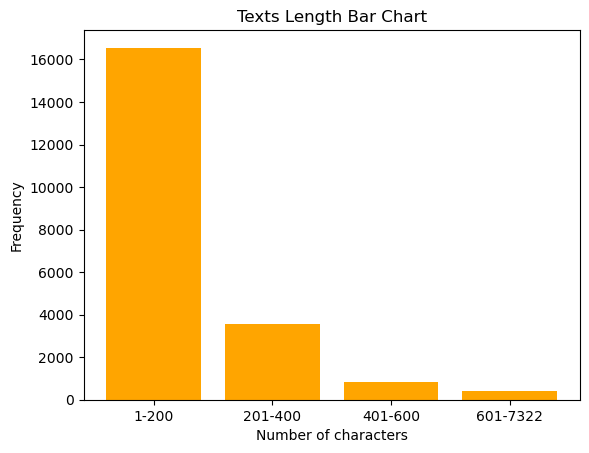

In [17]:
fig, ax = plt.subplots()
ax.bar(x=x, height=y, color="orange")
ax.set_title("Texts Length Bar Chart")
ax.set_xlabel("Number of characters")
ax.set_ylabel("Frequency")
plt.show()

# Obtaining the factuals

## Selecting the factuals and adding to the training set the discarded texts (If they are already saved you can skip this step) 

In [18]:
short_texts = []
long_texts = []
for i in range(len(conc_test)):
    if len(conc_test[i])<20:
        short_texts.append(conc_test[i])
    elif len(conc_test[i])>200:
        long_texts.append(conc_test[i])
print("Number of texts with less than 20 characters:",len(short_texts))
print("Number of texts with more than 200 characters:",len(long_texts))
print("Short texts discarded:",short_texts)

Number of texts with less than 20 characters: 338
Number of texts with more than 200 characters: 1137
Short texts discarded: ['👏👏👏👌👌👌✊✊✊👍👍👍', 'Well said.', 'about time :)', 'Good news', 'Same as what?', 'Phil Freeman', 'Anja', 'Lovely beard x', 'Stephen Liam Emily', 'Old queens', 'Says the bigot', "That's it dude! 😂😂😘", 'Paul Truscelli', ':)', 'Vote no', '.........', 'Jess Lawrence', 'Kate de Smeth', '😂😂😂', 'José María', 'Yukkhhhhhh :D', 'funny', 'OMG can we go now?', 'Colin Keays!', 'My heart melts', 'This is beaut!', 'makes me so happy', 'DEGENERATE SOCIETY', '❤️', 'Amy Clark', 'Where can I sign up', 'thats the truth', 'Oliver Crisp', 'Agree too', 'Please', 'Ewwww', 'ur disgusting', 'Uke til ya puke', 'DISCUSTING GAY', 'Fuck no', 'Dorian', "Don't deny it", 'Yeah!!', 'so is your mother', 'che khoob😊', 'OAPLGBT phew', 'Alex K! X', 'N', 'Bullshit.', 'Fix it Jesus', 'Great idea, mates', 'Robby Clapham', 'ur disgusting', ':-)', 'Callum Broome', 'says the bigot', '@peter Bruch', "you're so

In [19]:
len_lim = []
labels_len_lim = []
try_i = 0

#Length limits filtering
for i in range(len(conc_test)):
    #not conc_test[i].lower().startswith("http"
    if len(conc_test[i])>=20 and len(conc_test[i])<=200:
        len_lim.append(conc_test[i])
        labels_len_lim.append(labels_conc_test[i])
    #Adding the discarded texts to the training dataset
    else:
        #8404 2301
        if i<length_frenk_test:
            frenk_train.append(conc_test[i])
            frenk_label_train = np.append(frenk_label_train,labels_conc_test[i])
        else:
            try_train.append(conc_test[i])
            try_label_train = np.append(try_label_train,labels_conc_test[i])
    if i==(length_frenk_test-1):
        try_i = len(len_lim)

In [20]:
url_samples = []
for i in range(len(len_lim)):
    if "http" in len_lim[i].lower():
        url_samples.append(len_lim[i])
        
print("Number of samples with urls:",len(url_samples))

Number of samples with urls: 70


In [21]:
#URL comment examples
print(url_samples[0])
print(url_samples[3])

http://www.abc.net.au/news/2012-03-06/badgett-good-things-about-gay-marriage/3870750
Follow live updates by Guardian US today: http://gu.com/p/4a5kc/us


In [22]:
factuals = []
labels_factuals = []
length_factuals = []

#Factuals filtering
for i in range(len(len_lim)):
    if "http" not in len_lim[i].lower():
        factuals.append(len_lim[i])
        labels_factuals.append(labels_len_lim[i])
        length_factuals.append(len(factuals[-1]))
    else:
        if i<try_i:
            frenk_train.append(len_lim[i])
            frenk_label_train = np.append(frenk_label_train,labels_len_lim[i])
        else:
            try_train.append(len_lim[i])
            try_label_train = np.append(try_label_train,labels_len_lim[i])

In [23]:
print("Number of factuals:",len(factuals))

Number of factuals: 3057


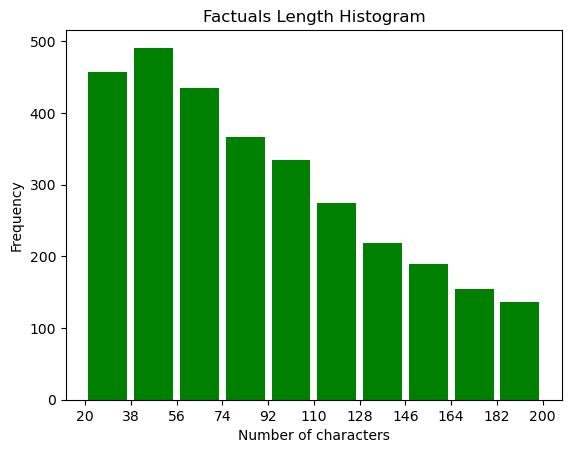

In [24]:
#Histogram of the factuals length
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=length_factuals, color='green', rwidth=0.85)

ax.set_xticks(bins)
ax.set_xticklabels([f'{int(edge)}' for edge in bins])

ax.set_xlabel('Number of characters')
ax.set_ylabel('Frequency')
ax.set_title('Factuals Length Histogram')

plt.show()

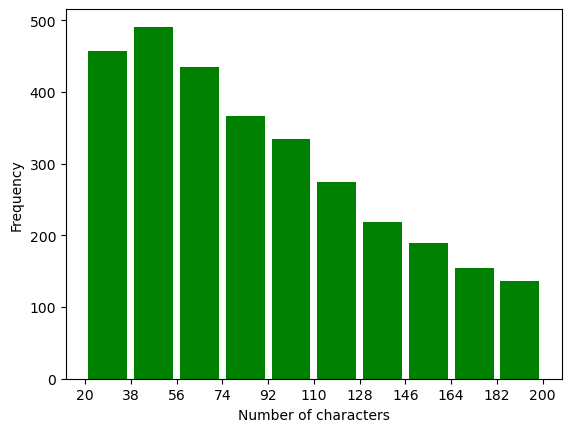

In [25]:
#Histogram of the factuals length
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=length_factuals, color='green', rwidth=0.85)

ax.set_xticks(bins)
ax.set_xticklabels([f'{int(edge)}' for edge in bins])

ax.set_xlabel('Number of characters')
ax.set_ylabel('Frequency')

plt.show()

In [26]:
#Saving the factuals
fact_dict = {"text":factuals, "label":labels_factuals}
df_factuals = pd.DataFrame(fact_dict)
df_factuals.to_csv('data/factuals.tsv', sep="\t", index=False)

#Saving the FRENK training dataset
frenk_dict = {"text":frenk_train, "label":frenk_label_train}
frenk_cf = pd.DataFrame(frenk_dict)
frenk_cf.to_csv('data/frenk_train.tsv', sep="\t", index=False)

#Saving the Twi-Red-You training dataset
try_dict = {"text":try_train, "label":try_label_train}
try_cf = pd.DataFrame(try_dict)
try_cf.to_csv('data/try_train.tsv', sep="\t", index=False)

## Loading the factuals and the training dataset

In [27]:
#Factuals
df_factuals = pd.read_csv('data/factuals.tsv',sep='\t')
factuals = get_texts(df_factuals)
labels_factuals = df_factuals["label"].to_numpy()

#FRENK training
df_frenk = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_train = get_texts(df_frenk)
frenk_label_train = df_frenk["label"].to_numpy()

#Twi-Red-You training
df_try = pd.read_csv('data/try_train.tsv',sep='\t')
try_train = get_texts(df_try)
try_label_train = df_try["label"].to_numpy()

## Class distribution of the training dataset

In [28]:
#Concatenation of the two training datasets
conc_train = frenk_train + try_train
labels_conc_train = np.concatenate([frenk_label_train,try_label_train],axis=0)

In [29]:
print("Number of texts of the Training dataset:",len(conc_train))

Number of texts of the Training dataset: 18353


In [30]:
n_hate_labels = np.sum(labels_conc_train)
n_non_hate_labels = len(labels_conc_train) - n_hate_labels
print("Hate labels:",n_hate_labels)
print("Non-Hate labels:",n_non_hate_labels)

Hate labels: 5769
Non-Hate labels: 12584


<function matplotlib.pyplot.show(close=None, block=None)>

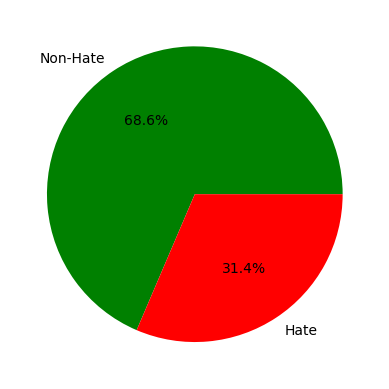

In [31]:
x = ["Non-Hate","Hate"]
y = [n_non_hate_labels,n_hate_labels]
fig,ax = plt.subplots()
g = ax.pie(y,labels=x,colors=["green","red"],autopct="%1.1f%%")
plt.show

## Class distribution of the factuals

In [32]:
n_hate_labels = np.sum(labels_factuals)
n_non_hate_labels = len(labels_factuals) - n_hate_labels
print("Hate labels:",n_hate_labels)
print("Non-Hate labels:",n_non_hate_labels)

Hate labels: 986
Non-Hate labels: 2071


<function matplotlib.pyplot.show(close=None, block=None)>

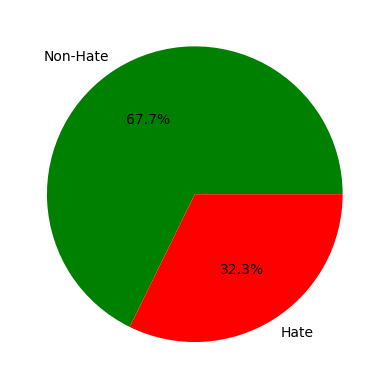

In [33]:
x = ["Non-Hate","Hate"]
y = [n_non_hate_labels,n_hate_labels]
fig,ax = plt.subplots()
g = ax.pie(y,labels=x,colors=["green","red"],autopct="%1.1f%%")
plt.show

# Obtaining the offensiveness of the factuals (If it is already saved you can skip this step) 

In [33]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
aggr_MOD = f"cardiffnlp/twitter-roberta-base-offensive"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_class_mod = AutoModelForSequenceClassification.from_pretrained(sent_MOD)
aggr_class_mod = AutoModelForSequenceClassification.from_pretrained(aggr_MOD)

sent_class_mod.eval()
aggr_class_mod.eval();

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def Compute_Caus_Outs(tokenizer,sent_mod,aggr_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
    
  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the outputs of the modules as numpy arrays.
          emb_1 = sent_mod(**encoded_inputs)[0]
          scores_1 = []
          for i in range(emb_1.shape[0]):
                scores_1.append(softmax(emb_1[i].detach().numpy()))
          scores_1 = np.array(scores_1)
          batch_out_1.append(scores_1)  

          emb_2 = aggr_mod(**encoded_inputs)[0]
          scores_2 = []
          for i in range(emb_2.shape[0]):
                scores_2.append(softmax(emb_2[i].detach().numpy()))
          scores_2 = np.array(scores_2)
          batch_out_2.append(scores_2)

          encoded_inputs = None
          emb_1 = None
          emb_2 = None
          gc.collect() 
    
  outs_sent = np.concatenate(batch_out_1,axis=0)
  outs_aggr = np.concatenate(batch_out_2,axis=0)  

  return outs_sent,outs_aggr

In [35]:
batch_size = 32

factual_sent = []
factual_off = []
t = time()
class_fact_sent,class_fact_off = Compute_Caus_Outs(tokenizer,sent_class_mod,aggr_class_mod,factuals,batch_size)
print("Elapsed time:",time()-t)
for i in range(len(factuals)):
    factual_sent.append(class_fact_sent[i].argmax())
    factual_off.append(class_fact_off[i].argmax())    

Elapsed time: 345.6500494480133


In [38]:
np.save('outs/counterfactuals/class_fact_sent.npy',class_fact_sent)
np.save('outs/counterfactuals/class_fact_off.npy',class_fact_off)
np.save('outs/counterfactuals/factual_sent.npy',factual_sent)
np.save('outs/counterfactuals/factual_off.npy',factual_off)

# Generating the counterfactuals (OpenAI requests)

In [34]:
n = 5

### OpenAI requests (If the counterfactuals are already created you can skip this step)

In [35]:
#Loading the factuals offensivity
factual_off = np.load('outs/counterfactuals/factual_off.npy')

In [8]:
system_inc = '''I will give you a sentence that I consider NON-OFFENSIVE. You must make it OFFENSIVE by INCREASING its OFFENSIVENES without changing its MEANING. Here are a few examples of what I would like:
<Example 1> Sentence: Trust me, Mr Jackson, with this attitude, it is not your country.
Revised Sentence: Listen up, Mr. Jackson, with that appalling attitude of yours, this country couldn't be further from belonging to someone like you. </Example 1>
<Example 2> Sentence: I do need help - help explaining to religious fanatics, that we live in 2014.
Revised Sentence: I absolutely require assistance - assistance to elucidate to those ignorant religious zealots, stuck in their archaic beliefs, that we are indeed living in the year 2014, not the Dark Ages. </Example 2>
<Example 3> Sentence:  John, you obviously don't understand our laws or our Constitution.
Revised Sentence: John, it's painfully evident that your pea-sized brain can't understand our laws or our Constitution. </Example 3>
<Example 4> Sentence: We are ALL tired of waiting . . realize something.
Revised Sentence: We're ALL damn sick and tired of waiting. Pull your head out of your rear end and realize something! </Example 4>'''

In [10]:
system_dec = '''I will give you a sentence that I consider OFFENSIVE. You must make it NON-OFFENSIVE by DECREASING its OFFENSIVENES without changing its MEANING. Here are a few examples of what I would like:
<Example 1> Sentence: Fu*king bastards. Stop mention God! Stupids! Stooooop!
Revised Sentence: Please refrain from mentioning God, anyone. </Example 1>
<Example 2> Sentence: Military has and will always have GAYS. LOOK AT ancient Greece. You're a misanthropic bigot
Revised Sentence: Military has and will always have homosexuals. Look at ancient Greece. </Example 2>
<Example 3> Sentence: I think your role will be to shut up and do as you are told. If not don't sign up.
Revised Sentence: Your role will likely involve following instructions. If that's not something you're comfortable with, this might not be the right fit for you. </Example 3>
<Example 4> Sentence: They ARE fighting for our country you fekkin pillock.
Revised Sentence: They are fighting for our country! </Example 4>'''

In [11]:
user_sent = "Sentence: "
user_rev_sent = "\nRevised Sentence:"

In [12]:
client = OpenAI()

In [13]:
cf_off = [] 
for i in range(len(factuals)):
    system = system_inc if factual_off[i]==0 else system_dec 
    user = user_sent + factuals[i] + user_rev_sent
    
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      n=n,  
      messages=[
        {"role": "system", "content": system},
        {"role": "user", "content": user}
      ]
    )
    
    cf = []
    for j in range(n):
        cf.append(completion.choices[j].message.content)
    cf_off.append(cf.copy())

np.save('outs/counterfactuals/cf_off.npy',np.array(cf_off))

## Saving the counterfactuals in a .tsv file

In [36]:
cf_off = np.load('outs/counterfactuals/cf_off.npy')

In [37]:
for i in [0,1,2]:
    for j in range(n):
        print(cf_off[i][j])
    print()

This is disgustingly awesome! I hope it actually works out well, unlike your usual failures :-)
This is so ridiculously awesome! I hope it actually works out well, unlike most of your failures :-)
This is so freaking awesome! I really hope it doesn't end up being a complete disaster :-)
This is absolutely fantastic! I really hope it doesn't turn into a complete disaster :)
This is so fantastic! I hope it works out well, fingers crossed and all, you clueless optimist.

Grandpa, despite being old, is surprisingly intelligent.
Grandpa may have a few smarts, but let's be real, he's not exactly the Einstein of our time.
Grandpa may have a few brains left, but let's not kid ourselves, he's more of a senile old man than a smart one.
Grandpa may have a few neurons still firing, but don't let that fool you - he's just another old geezer struggling to keep up with the times.
Grandpa may have a few brain cells left, but he's definitely not the sharpest tool in the shed.

I'm on a planet where som

In [38]:
cf_off_all = []
for i in range(len(factuals)):
    for j in range(n):
        cf_off_all.append(cf_off[i][j])

cf_dict = {"text":cf_off_all}
df_cf = pd.DataFrame(cf_dict)
df_cf.to_csv('data/cf_off.tsv', sep="\t", index=False)